In [1]:
# stage6_end_to_end.py
from langgraph.graph import StateGraph, MessagesState, END
from langchain_openai import ChatOpenAI
from langchain.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
import wikipedia
import json
import os
from typing import List
from dotenv import load_dotenv
from typing import List, Dict, Annotated
from langgraph.graph.message import add_messages # Import add_messages
load_dotenv("../../config/local.env")

c:\Users\ytiam\notebooks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ytiam\notebooks\.venv\Lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find cuobjdump.exe
  warnings.warn(f"Failed to find {binary}")
c:\Users\ytiam\notebooks\.venv\Lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find nvdisasm.exe
  warnings.warn(f"Failed to find {binary}")


True

In [2]:

# ---------- Config ----------
MODEL = "gpt-4o-mini"
EVAL_THRESHOLD = 8
MAX_REVISE_ITER = 2
CHECKPOINT_FILE = "agent_checkpoints.json"

# ---------- Helpers: simple file memory ----------
def load_checkpoints():
    if os.path.exists(CHECKPOINT_FILE):
        with open(CHECKPOINT_FILE, "r", encoding="utf-8") as f:
            return json.load(f)
    return {}

def save_checkpoint(key, value):
    data = load_checkpoints()
    data[key] = value
    with open(CHECKPOINT_FILE, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

In [ ]:
# ---------- Tools ----------

@tool
def wiki_search(query: str) -> str:
    """Search Wikipedia for a summary on the given query."""
    try:
        return wikipedia.summary(query, sentences=2)
    except Exception:
        return "No summary found."

@tool
def calculator(expression: str) -> str:
    """Evaluate a mathematical expression."""
    try:
        return str(eval(expression))
    except Exception as e:
        return f"Error: {e}"
    

TOOLS = [wiki_search, calculator]

# ---------- LLM ----------
llm = ChatOpenAI(model=MODEL)

In [4]:
import operator # Import the operator module

class CustomMessagesState(MessagesState):
    draft: str
    feedback: str
    score: int
    task: str
    revise_iter: int
    subtasks: str
    subtask_index: int
    research: Annotated[List[Dict], operator.add]
    next_node: str
    tool_args: str
    last_research_msg: str

In [5]:

# ---------- System prompts ----------
SYSTEM_PLANNER = SystemMessage(content="You are a planner that breaks a high-level task into 3 short subtasks.")
SYSTEM_RESEARCH = SystemMessage(content=(
    "You are a researcher that decides which tool to call. "
    "Return an LLM response that may include a tool_call if you need external data."
))
SYSTEM_WRITER = SystemMessage(content="You are a writer. Synthesize the provided research into a concise, clear answer.")
SYSTEM_EVALUATOR = SystemMessage(content="You are an evaluator. Score from 1-10 and provide short critique and improvement points.")

In [ ]:

# # ---------- Node implementations ----------
# def planner_node(state: CustomMessagesState):
#     user_task = state["task"]
#     # simple decomposition prompt
#     prompt = f"Task: {user_task}\nBreak this into 3 short subtasks (one sentence each)."
#     resp = llm.invoke([SYSTEM_PLANNER, HumanMessage(content=prompt)])
#     subtasks = [s.strip() for s in resp.content.split("\n") if s.strip()]
#     # fallback if LLM didn't give 3 lines
#     if len(subtasks) < 1:
#         subtasks = [user_task]
#     return {"subtasks": subtasks, "subtask_index": 0, "research": []}

# def researcher_node(state: CustomMessagesState):
#     print("Researcher State subtasks:", state["subtasks"])
#     idx = state["subtask_index"]
#     subtasks: List[str] = state["subtasks"]
#     if idx >= len(subtasks):
#         # nothing left
#         return {}
#     current = subtasks[idx]
#     # create messages including system and brief history
#     messages = [SYSTEM_RESEARCH, HumanMessage(content=f"Research this: {current}")]
#     # allow model to call tools
#     response = llm.bind_tools(TOOLS).invoke(messages)

#     # If tool call -> handle via tool node (route will be to 'tool')
#     if response.tool_calls:
#         # carry needed context for tool node
#         return {
#             "research": state.get("research", []),
#             "subtasks": subtasks,
#             "subtask_index": idx,
#             "next_node": response.tool_calls[0]["name"],
#             "tool_args": response.tool_calls[0]["args"],
#             "last_research_msg": response  # store the model message that requested the tool
#         }

#     # If no tool call, treat response as observation/result
#     observations = state.get("research", []) + [{"subtask": current, "result": response.content}]
#     return {
#         "research": observations,
#         "subtasks": subtasks,
#         "subtask_index": idx + 1
#     }

# def tool_node(state: CustomMessagesState):
#     subtasks = state.get("subtasks", [])
#     idx = state.get("subtask_index", 0)

#     # Safety check
#     if not subtasks or idx >= len(subtasks):
#         print("⚠️ [tool_node] No valid subtask found, skipping tool execution.")
#         return {
#             "research": state.get("research", []),
#             "subtasks": subtasks,
#             "subtask_index": idx,
#         }
#     tool_name = state["next_node"]
#     tool_args = state["tool_args"]
#     last_model_msg = state["last_research_msg"]
#     # execute appropriate tool
#     result = None
#     for t in TOOLS:
#         if t.name == tool_name:
#             result = t.invoke(tool_args)
#             break
#     if result is None: 
#         result = f"Tool {tool_name} not found."

#     # Build a ToolMessage linked to the tool_call_id from the stored model message
#     tool_call_id = None
#     if hasattr(last_model_msg, "tool_calls") and last_model_msg.tool_calls:
#         tool_call_id = last_model_msg.tool_calls[0]["id"]
#     # if no id, generate a safe fallback
#     if not tool_call_id:
#         tool_call_id = "auto_tool_call"

#     tool_msg = ToolMessage(content=result, tool_call_id=tool_call_id)
#     # append tool observation into research history
#     observations = state.get("research", []) + [{"subtask": state["subtasks"][state["subtask_index"]], "result": result}]
#     return {
#         "research": observations,
#         "subtasks": state["subtasks"],
#         "subtask_index": state["subtask_index"] + 1  # move to next subtask after tool result
#     }

# def writer_node(state: CustomMessagesState):
#     # gather all research into a single prompt
#     research = state.get("research", [])
#     topic = state.get("task")
#     research_text = "\n".join([f"- {r['subtask']}: {r['result']}" for r in research])
#     prompt = f"Topic: {topic}\nResearch gathered:\n{research_text}\n\nWrite final answer (concise)."
#     resp = llm.invoke([SYSTEM_WRITER, HumanMessage(content=prompt)])
#     return {"draft": resp.content, "research": research, "task": topic, "revise_iter": 0}

# def evaluator_node(state: CustomMessagesState):
#     draft = state["draft"]
#     prompt = f"Text:\n{draft}\n\nScore 1-10 for clarity and accuracy, then give a 1-line critique and 1 improvement suggestion."
#     resp = llm.invoke([SYSTEM_EVALUATOR, HumanMessage(content=prompt)])
#     # crude score parsing
#     score = next((int(s) for s in resp.content.split() if s.isdigit()), None)
#     if score is None:
#         score = 7
#     return {"draft": draft, "feedback": resp.content, "score": score, "revise_iter": state.get("revise_iter", 0)}

# def reviser_node(state: CustomMessagesState):
#     draft = state["draft"]
#     feedback = state["feedback"]
#     iter_count = state.get("revise_iter", 0) + 1
#     prompt = f"Improve the draft based on this feedback:\nFeedback: {feedback}\n\nDraft:\n{draft}"
#     resp = llm.invoke([HumanMessage(content=prompt)])
#     return {"draft": resp.content, "revise_iter": iter_count, "feedback": state["feedback"], "score": state["score"], "task": state.get("task")}


In [ ]:
# ---------- Node implementations ----------
def planner_node(state: CustomMessagesState):
    user_task = state["task"]
    # simple decomposition prompt
    prompt = f"Task: {user_task}\nBreak this into 3 short subtasks (one sentence each)."
    resp = llm.invoke([SYSTEM_PLANNER, HumanMessage(content=prompt)])
    subtasks = [s.strip() for s in resp.content.split("\n") if s.strip()]
    # fallback if LLM didn't give 3 lines
    if len(subtasks) < 1:
        subtasks = [user_task]
    return {"subtasks": subtasks, "subtask_index": 0, "research": []}


def researcher_node(state: CustomMessagesState):
    print("Researcher State subtasks:", state["subtasks"])
    idx = state["subtask_index"]
    subtasks: List[str] = state["subtasks"]
    if idx >= len(subtasks):
        # nothing left
        return {} #{"done": True}
    current = subtasks[idx]
    # create messages including system and brief history
    messages = [SYSTEM_RESEARCH, HumanMessage(content=f"Research this: {current}")]
    # allow model to call tools
    response = llm.bind_tools(TOOLS).invoke(messages)

    # If tool call -> handle via tool node (route will be to 'tool')
    if response.tool_calls:
        # carry needed context for tool node
        return {
            "research": state.get("research", []),
            "subtasks": subtasks,
            "subtask_index": idx,
            "next_node": response.tool_calls[0]["name"],
            "tool_args": response.tool_calls[0]["args"],
            "last_research_msg": response  # store the model message that requested the tool
        }

    # If no tool call, treat response as observation/result
    observations = state.get("research", []) + [{"subtask": current, "result": response.content}]
    return {
        "research": observations,
        "subtasks": subtasks,
        "subtask_index": idx + 1
    }


def tool_node(state: CustomMessagesState):
    subtasks = state.get("subtasks", [])
    idx = state.get("subtask_index", 0)

    # Safety check
    if not subtasks or idx >= len(subtasks):
        print("[tool_node] No valid subtask found, skipping tool execution.")
        #return {"done": True}
        return {
            "research": state.get("research", []),
            "subtasks": subtasks,
            "subtask_index": idx,
            "next_node": None,
        }
    tool_name = state["next_node"]
    tool_args = state["tool_args"]
    last_model_msg = state["last_research_msg"]
    # execute appropriate tool
    result = None
    for t in TOOLS:
        if t.name == tool_name:
            result = t.invoke(tool_args)
            break
    if result is None: 
        result = f"Tool {tool_name} not found."

    # Build a ToolMessage linked to the tool_call_id from the stored model message
    tool_call_id = None
    if hasattr(last_model_msg, "tool_calls") and last_model_msg.tool_calls:
        tool_call_id = last_model_msg.tool_calls[0]["id"]
    # if no id, generate a safe fallback
    if not tool_call_id:
        tool_call_id = "auto_tool_call"

    tool_msg = ToolMessage(content=result, tool_call_id=tool_call_id)
    # append tool observation into research history
    observations = state.get("research", []) + [{"subtask": state["subtasks"][state["subtask_index"]], "result": result}]
    return {
        "research": observations,
        "subtasks": state["subtasks"],
        "subtask_index": state["subtask_index"] + 1,  # move to next subtask after tool result
    }


def writer_node(state: CustomMessagesState):
    # gather all research into a single prompt
    research = state.get("research", [])
    topic = state.get("task")
    research_text = "\n".join([f"- {r['subtask']}: {r['result']}" for r in research])
    prompt = f"Topic: {topic}\nResearch gathered:\n{research_text}\n\nWrite final answer (concise)."
    resp = llm.invoke([SYSTEM_WRITER, HumanMessage(content=prompt)])
    return {"draft": resp.content, "research": research, "task": topic, "revise_iter": 0}

def evaluator_node(state: CustomMessagesState):
    draft = state["draft"]
    prompt = f"Text:\n{draft}\n\nScore 1-10 for clarity and accuracy, then give a 1-line critique and 1 improvement suggestion."
    resp = llm.invoke([SYSTEM_EVALUATOR, HumanMessage(content=prompt)])
    # crude score parsing
    score = next((int(s) for s in resp.content.split() if s.isdigit()), None)
    if score is None:
        score = 7
    return {"draft": draft, "feedback": resp.content, "score": score, "revise_iter": state.get("revise_iter", 0)}


def reviser_node(state: CustomMessagesState):
    draft = state["draft"]
    feedback = state["feedback"]
    iter_count = state.get("revise_iter", 0) + 1
    prompt = f"Improve the draft based on this feedback:\nFeedback: {feedback}\n\nDraft:\n{draft}"
    resp = llm.invoke([HumanMessage(content=prompt)])
    return {"draft": resp.content, "revise_iter": iter_count, "feedback": state["feedback"], "score": state["score"], "task": state.get("task")}


# def route_researcher(state: CustomMessagesState):
#     if state.get("done"):
#         return END
#     elif "next_node" in state:
#         return "tool"
#     else:
#         return "researcher"


def route_researcher(state: CustomMessagesState):
    if ("next_node" in state) and (state["next_node"] is not None):
        return "tool"
    
    idx = state.get("subtask_index", 0)
    subtasks = state.get("subtasks", [])
    
    # Check if there are still subtasks left to process
    if idx < len(subtasks):
        return "researcher"
    else:
        # All subtasks complete
        return "writer"
    

# def route_tool(state):
#     if state.get("done"):
#         return END
#     else:
#         return "researcher"

def route_eval(state:CustomMessagesState):
    score = state.get("score", 0)
    revise_iter = state.get("revise_iter", 0)
    if score < EVAL_THRESHOLD and revise_iter < MAX_REVISE_ITER:
        return "reviser"
    else:
        return END

#-----------------------------------------------

builder1 = StateGraph(CustomMessagesState)

builder1.add_node("planner", planner_node)
builder1.add_node("researcher", researcher_node)
builder1.add_node("tool", tool_node)
builder1.add_node("writer", writer_node)
builder1.add_node("evaluator", evaluator_node)
builder1.add_node("reviser", reviser_node)

builder1.set_entry_point("planner")
builder1.add_edge("planner", "researcher")

builder1.add_conditional_edges("researcher", route_researcher, {"tool": "tool", "writer": "writer"})
# builder1.add_conditional_edges("tool", route_tool, {"researcher": "researcher", END: END})
builder1.add_edge("tool", "researcher")

builder1.add_edge("writer", "evaluator")
builder1.add_conditional_edges("evaluator", route_eval, {"reviser": "reviser", END: END})
builder1.add_edge("reviser", "evaluator")


graph1 = builder1.compile()

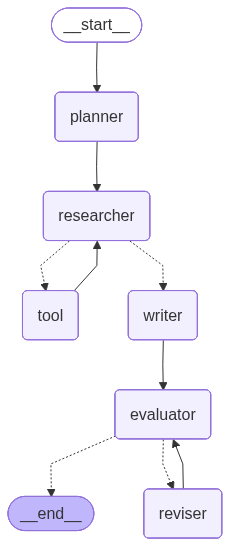

In [8]:
graph1

In [11]:
init_state = {"task": "How a multiagent system can collaboratively solve complex problems using external tools and iterative refinement? Help me to understand step by step."}
result = graph1.invoke(init_state)

Researcher State subtasks: ['1. Identify and define the complex problem to be solved by the multiagent system, ensuring clarity on objectives and constraints.', '2. Implement mechanisms for agents to share information and external tools that enhance their individual capabilities, enabling collaboration in the solution process.', '3. Establish an iterative refinement loop where agents assess the effectiveness of proposed solutions, provide feedback, and collaboratively improve outcomes based on shared insights.']
Researcher State subtasks: ['1. Identify and define the complex problem to be solved by the multiagent system, ensuring clarity on objectives and constraints.', '2. Implement mechanisms for agents to share information and external tools that enhance their individual capabilities, enabling collaboration in the solution process.', '3. Establish an iterative refinement loop where agents assess the effectiveness of proposed solutions, provide feedback, and collaboratively improve o

In [12]:
print(result["draft"])

A multiagent system (MAS) collaboratively solves complex problems through a structured approach:

1. **Problem Definition**: Clearly identify and define the complex problem, including objectives and constraints. This ensures that all agents understand the goal and the parameters within which they must operate.

2. **Information Sharing and Tool Integration**: Implement mechanisms that allow agents to share information and utilize external tools. This enhances the individual capabilities of agents and promotes collaborative problem-solving.

3. **Iterative Refinement**: Establish a feedback loop where agents evaluate the proposed solutions and refine them collaboratively. This iterative process allows agents to learn from each other's insights, improving the overall effectiveness of the solutions over time.

By following these steps, a MAS can effectively address complex challenges through cooperation and iterative learning.
